In [1]:
import mosaicmpipipipi as cn
cn.start_logging()

2023-07-31 10:32:44,826 [INFO] mosaicMPI version 1.0.12


## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [2]:
import pandas as pd

rna_data = pd.read_table("cptac_data/cptac_RNA.txt", index_col=0)
rna_metadata = pd.read_table("cptac_data/cptac_RNA.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
rna = cn.Dataset.from_df(data=rna_data, obs=rna_metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [3]:
# write to .h5ad file
rna.write_h5ad("rna.h5ad")
# read from .h5ad file
rna = cn.Dataset.from_h5ad("rna.h5ad")

2023-07-31 10:32:46,191 [INFO] Writing to c:\Users\verhe\github\mosaicMPI\tutorial\rna.h5ad
2023-07-31 10:32:46,242 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [4]:
rna.adata

AnnData object with n_obs × n_vars = 108 × 19444
    obs: 'patient_id', 'simple_category', 'detailed_category', 'purity_TSNet', 'multiomic', 'r_wang_cancer_cell_2017', 'd_methyl', 'd_methyl_mnp', 'is_gcimp', 'immune', 'mir'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg', 'patient_id_col'

mosaicMPI can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [5]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset(pbmc_adata)

## Selecting overdispersed genes

2023-07-31 10:32:46,780 [INFO] 8466 genes selected for factorization


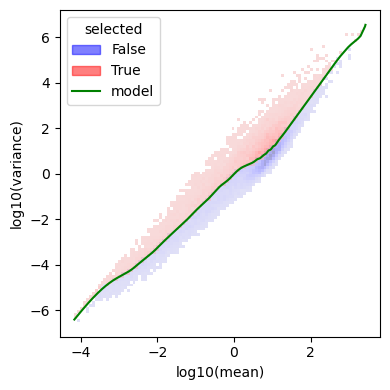

In [6]:
# calculates overdispersion for each gene
rna.compute_gene_stats(odg_default_spline_degree=3, odg_default_dof=30)  # calculates gene statistics and stores in the Dataset object

# thresholds for gene overdispersion
rna.select_overdispersed_genes(overdispersion_metric="odscore", min_score=1)
fig = cn.plot_feature_dispersion(rna, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 40-50% of genes as being overdispersed:

In [7]:
rna.adata.var["selected"].value_counts()

False    10978
True      8466
Name: selected, dtype: int64

## Factorization

In [8]:
cnmf_results_dir = "cnmf_results"
run_name = "rna"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = rna.initialize_cnmf(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name, kvals=kvals, n_iter=n_iter)


# these steps take long

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
rna.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
rna.write_h5ad("rna.h5ad")  # overwrite original file

2023-07-31 10:34:20,292 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-07-31 10:34:20,293 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-07-31 10:34:20,294 [INFO] Creating consensus GEPs and usages for k=2
c:\Users\verhe\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
2023-07-31 10:34:22,494 [INFO] Creating consensus GEPs and usages for k=3
c:\Users\verhe\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
2023-07-31 10:34:24,570 [INFO] Creating consensus GEPs and usages for k=4
c:\Users\verhe\m

## Stability-Error Plot

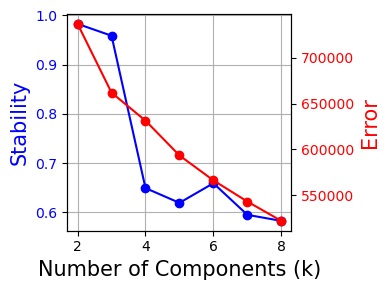

In [9]:
fig = cn.plot_stability_error(rna, figsize=[4,3])

fig.savefig("rna_stability-error.pdf")  # Save figures in PDF or PNG format

## Accessing program usage values

Get dataframe with usage of each program across samples

In [10]:
rna.get_usages().head()

2                   3                             4  \
                  1         2         1         2         3         1   
C3L-00104  0.168858  0.026762  0.113140  0.067397  0.017565  0.066636   
C3L-00365  0.183785  0.004145  0.111043  0.075467  0.001074  0.065974   
C3L-00674  0.200546  0.010512  0.068439  0.132409  0.007074  0.130422   
C3L-00677  0.180948  0.027280  0.138936  0.056577  0.016619  0.055241   
C3L-01040  0.156780  0.032766  0.114588  0.053466  0.024206  0.046323   

                                                5  ...         7            \
                  2         3         4         1  ...         6         7   
C3L-00104  0.063836  0.011690  0.046851  0.048313  ...  0.017245  0.019197   
C3L-00365  0.128070  0.000529  0.000534  0.140304  ...  0.001096  0.012198   
C3L-00674  0.052455  0.004525  0.018551  0.035635  ...  0.026128  0.001118   
C3L-00677  0.087656  0.010200  0.050346  0.074710  ...  0.019227  0.045702   
C3L-01040  0.129021  0.023718  0.000913  0.137506  ...  0.002330  0.006611   

                  8                                                    \
                  1         2         3         4         5         6   
C3L-00104  0.007344  0.032195  0.005375  0.035530  0.002440  0.081912   
C3L-00365  0.084881  0.051544  0.000030  0.001454  0.000337  0.046924   
C3L-00674  0.038612  0.071085  0.000957  0.020787  0.057568  0.002804   
C3L-00677  0.026428  0.013787  0.003871  0.025552  0.002125  0.088389   
C3L-01040  0.130564  0.014513  0.020920  0.006446  0.009187  0.009215   

                               
                  7         8  
C3L-00104  0.012325  0.009800  
C3L-00365  0.001367  0.004114  
C3L-00674  0.014465  0.001413  
C3L-00677  0.016338  0.019365  
C3L-01040  0.000694  0.008618  

[5 rows x 35 columns]

# Plotting program usages in a heatmap

2023-07-31 10:34:52,560 [INFO] Choosing distinct colors for metadata layer patient_id
2023-07-31 10:34:57,545 [INFO] Choosing distinct colors for metadata layer simple_category
2023-07-31 10:34:57,555 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-07-31 10:34:57,565 [INFO] Choosing distinct colors for metadata layer multiomic
2023-07-31 10:34:57,603 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-07-31 10:34:57,631 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-07-31 10:34:57,697 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-07-31 10:34:57,803 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-07-31 10:34:57,827 [INFO] Choosing distinct colors for metadata layer immune
2023-07-31 10:34:57,857 [INFO] Choosing distinct colors for metadata layer mir


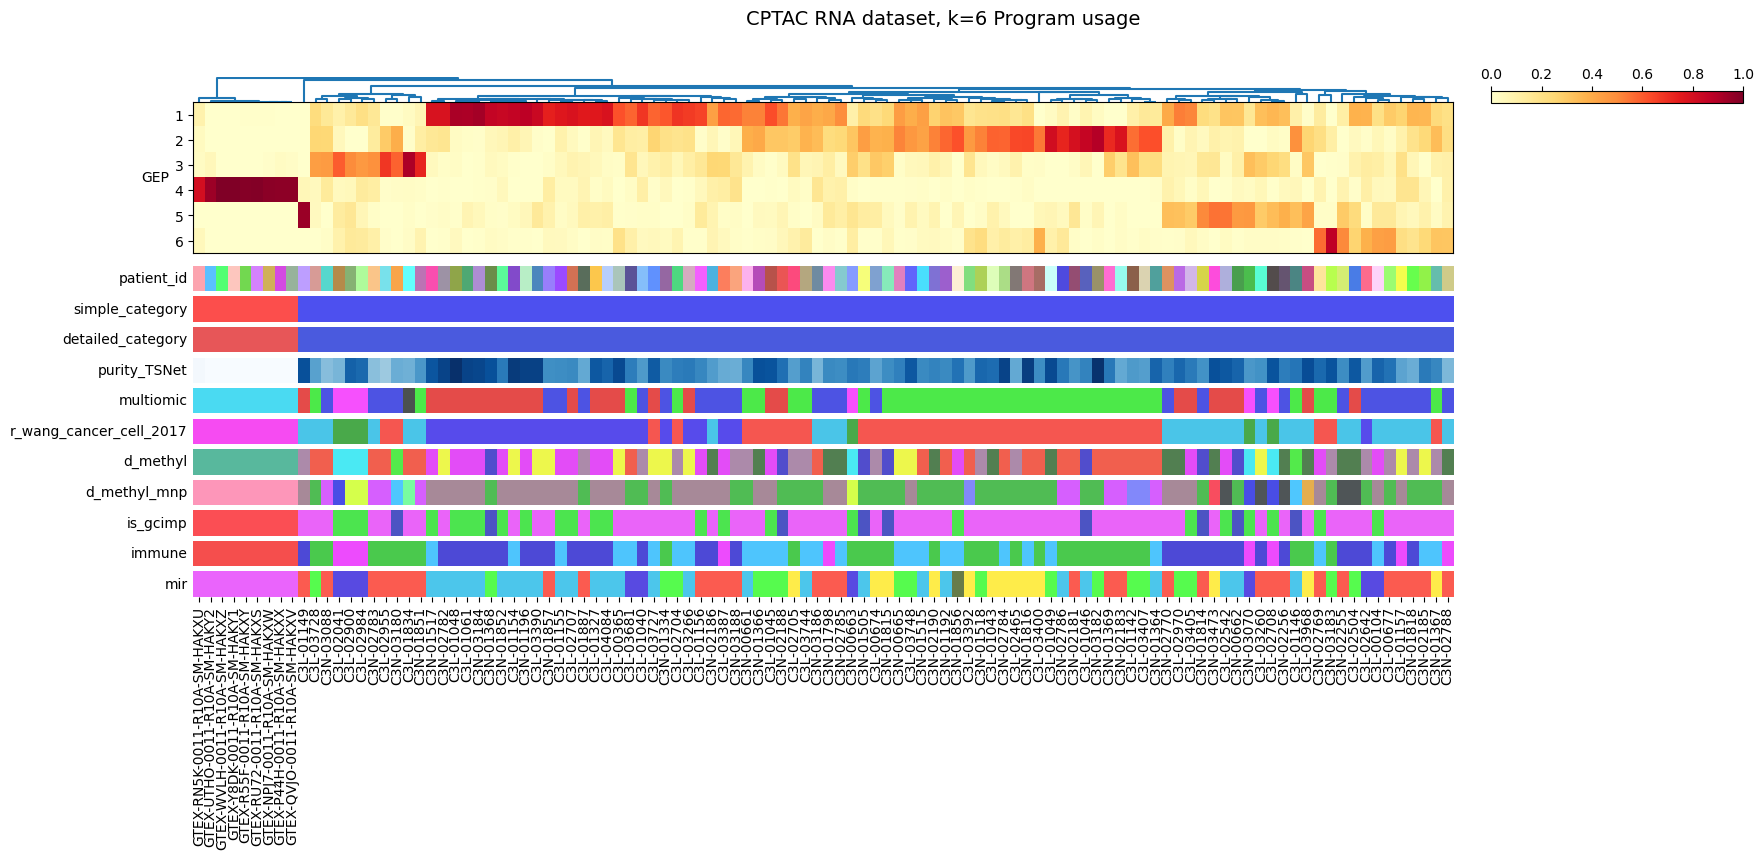

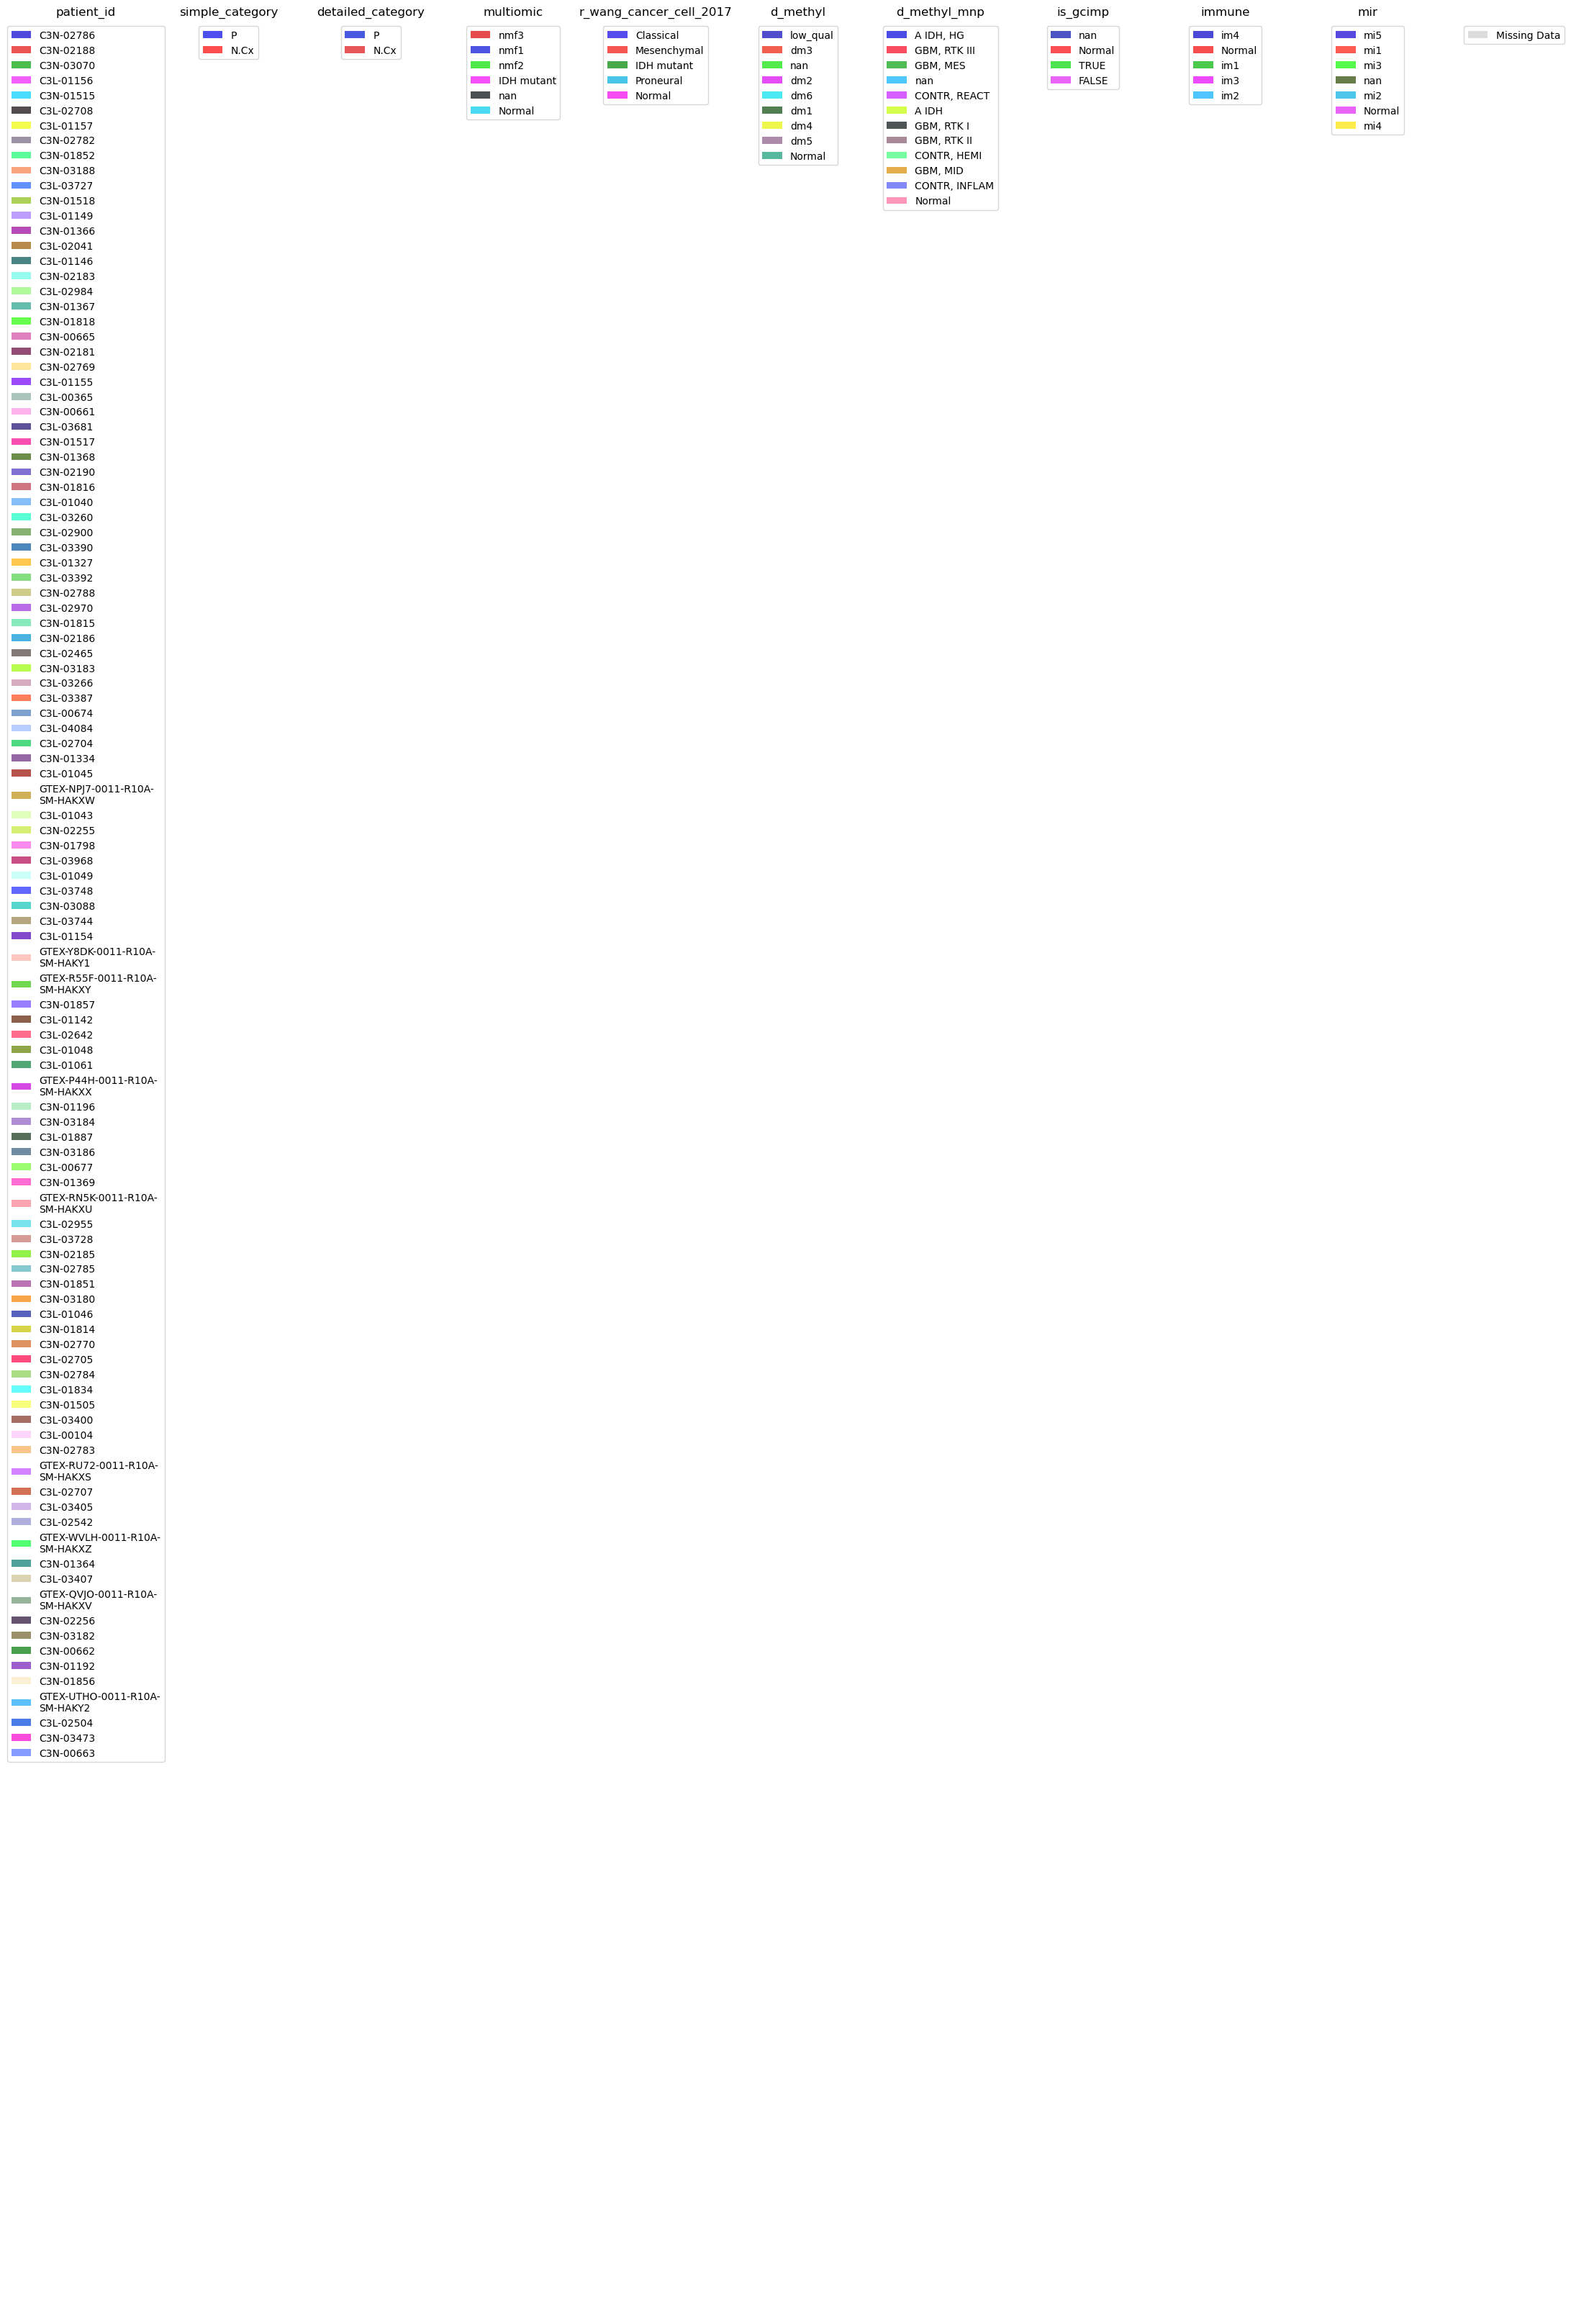

In [11]:
colors = cn.Colors.from_dataset(rna, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(rna, k=6, colors=colors,
                                     title="CPTAC RNA dataset, k=6 Program usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("rna_metadata_colors_legend.pdf")

## Factorize the proteomics data

In [12]:
data = pd.read_csv("cptac_data/cptac_protein.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_protein.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
protein = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
protein.compute_gene_stats()
protein.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "protein"
cnmf_run = protein.initialize_cnmf(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
protein.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
protein.write_h5ad("protein.h5ad")  # write to h5ad file

2023-07-31 10:35:06,455 [INFO] 4554 genes selected for factorization
2023-07-31 10:36:10,048 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-07-31 10:36:10,050 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-07-31 10:36:10,051 [INFO] Creating consensus GEPs and usages for k=2
c:\Users\verhe\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
2023-07-31 10:36:11,859 [INFO] Creating consensus GEPs and usages for k=3
c:\Users\verhe\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
2023-07-31 10:36:13,5

## Factorize the snRNA data

In [13]:
# Note that the snRNA data has been subsetted for the purposes of this tutorial
data = pd.read_table("cptac_data\cptac_snRNA_subsampled.txt", index_col=0, sep="\t")  # normalized counts
metadata = pd.read_table("cptac_data/cptac_snRNA_subsampled.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
snrna = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient")
snrna.compute_gene_stats()
snrna.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "snrna"
cnmf_run = snrna.initialize_cnmf(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
snrna.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
snrna.write_h5ad("snrna.h5ad")  # write to h5ad file

c:\Users\verhe\miniconda3\lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
2023-07-31 10:36:35,755 [INFO] 6686 genes selected for factorization
2023-07-31 10:39:13,351 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-07-31 10:39:13,352 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-07-31 10:39:13,352 [INFO] Creating consensus GEPs and usages for k=2
c:\Users\verhe\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\verhe\github\mosaicMPI\src\cnmfsns\cnmf.py:560: RuntimeWarning: invalid value encountered in divide
  norm_tpm = (tpm.X - tpm_stats['__mean'].values) / tpm_stats['__std'].values
2023-07-31 10:39:16,545 [

## Integrate multiple datasets together

In [14]:
datasets = {"RNA": rna, "Protein": protein, "snRNA": snrna}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-07-31 10:39:53,814 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 8 CPUs.
2023-07-31 10:39:55,745 [INFO] Choosing distinct dataset colors
2023-07-31 10:39:55,780 [INFO] Choosing distinct colors for metadata layer patient_id
2023-07-31 10:39:55,976 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-07-31 10:39:55,987 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-07-31 10:39:56,006 [INFO] Choosing distinct colors for metadata layer immune
2023-07-31 10:39:56,016 [INFO] Choosing distinct colors for metadata layer TMT
2023-07-31 10:39:56,113 [INFO] Choosing distinct colors for metadata layer patient
2023-07-31 10:39:56,337 [INFO] Choosing distinct colors for metadata layer CellType
2023-07-31 10:39:56,409 [INFO] Choosing distinct colors for metadata layer RNA_subtype
2023-07-31 10:39:56,425 [INFO] Choosing distinct colors for metadata layer immune_subtype
2023-07-31 10:39:56,447 [INFO] Choosing distinct colors for m

Identify feature overlap between datasets

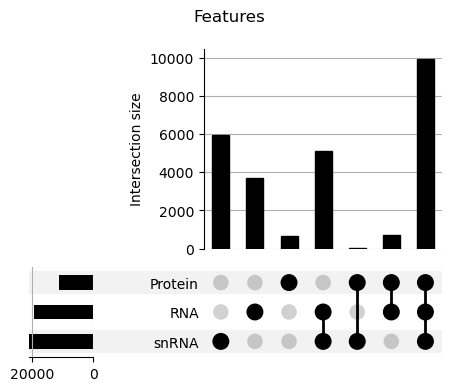

In [15]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

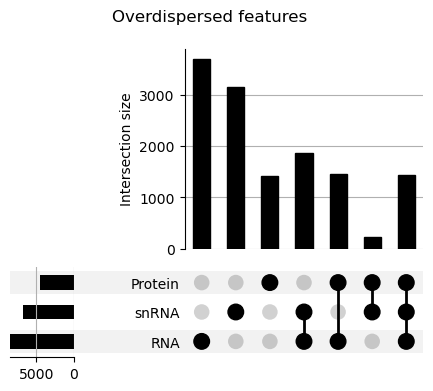

In [16]:
cn.plot_overdispersed_features_upset(integration)

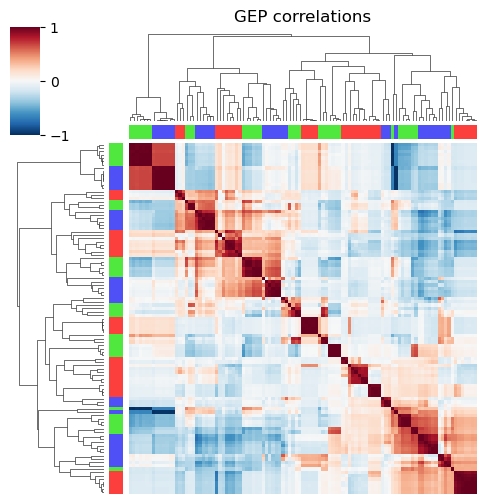

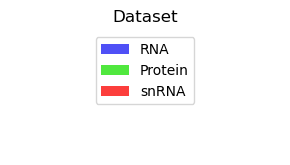

In [17]:
# plot the correlation matrix of all programs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [18]:
integration.k_table

Protein                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991563    297191.593750       True   
3        True              True         -0.464190    271496.250000       True   
4        True              True         -0.380641    254523.312500       True   
5        True              True         -0.198312    241524.703125       True   
6        True              True         -0.159454    231999.093750       True   
7        True              True         -0.132242    228457.265625       True   
8        True              True         -0.124881    221604.812500       True   

                    RNA                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.993169        True              True         -0.996284     736915.62500   
3  0.807015        True              True         -0.364498     661907.50000   
4  0.758947        True              True         -0.339903     631413.68750   
5  0.762381        True              True         -0.262620     593474.25000   
6  0.638065        True              True         -0.121445     566309.68750   
7  0.538783        True              True         -0.101012     543205.75000   
8  0.446863        True              True         -0.087254     522132.84375   

                             snRNA                                      \
  selected_k stability cNMF result max_k_filter_pass max_k_median_corr   
2       True  0.982954        True              True         -0.752618   
3       True  0.958919        True              True         -0.317631   
4       True  0.649183        True              True         -0.179543   
5       True  0.619173        True              True         -0.161890   
6       True  0.659030        True              True         -0.152568   
7       True  0.594821        True              True         -0.117773   
8       True  0.582522        True              True         -0.111723   

                                         
  prediction_error selected_k stability  
2      2070395.000       True  0.788480  
3      2046624.500       True  0.470045  
4      2016235.500       True  0.450841  
5      1994465.500       True  0.434658  
6      1981885.000       True  0.352046  
7      1961682.250       True  0.370266  
8      1952028.875       True  0.306931

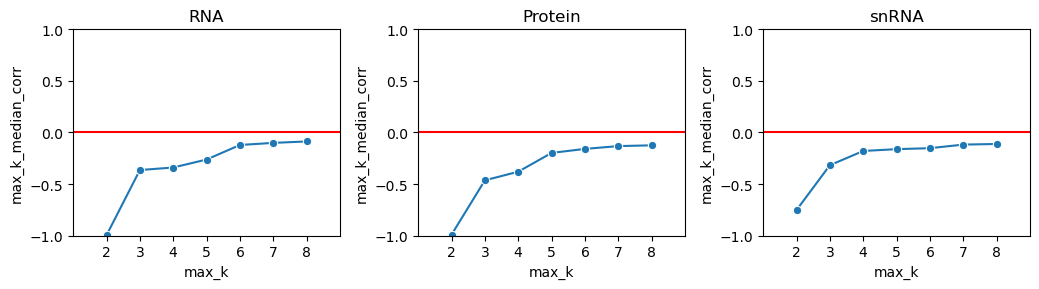

In [19]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for programs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

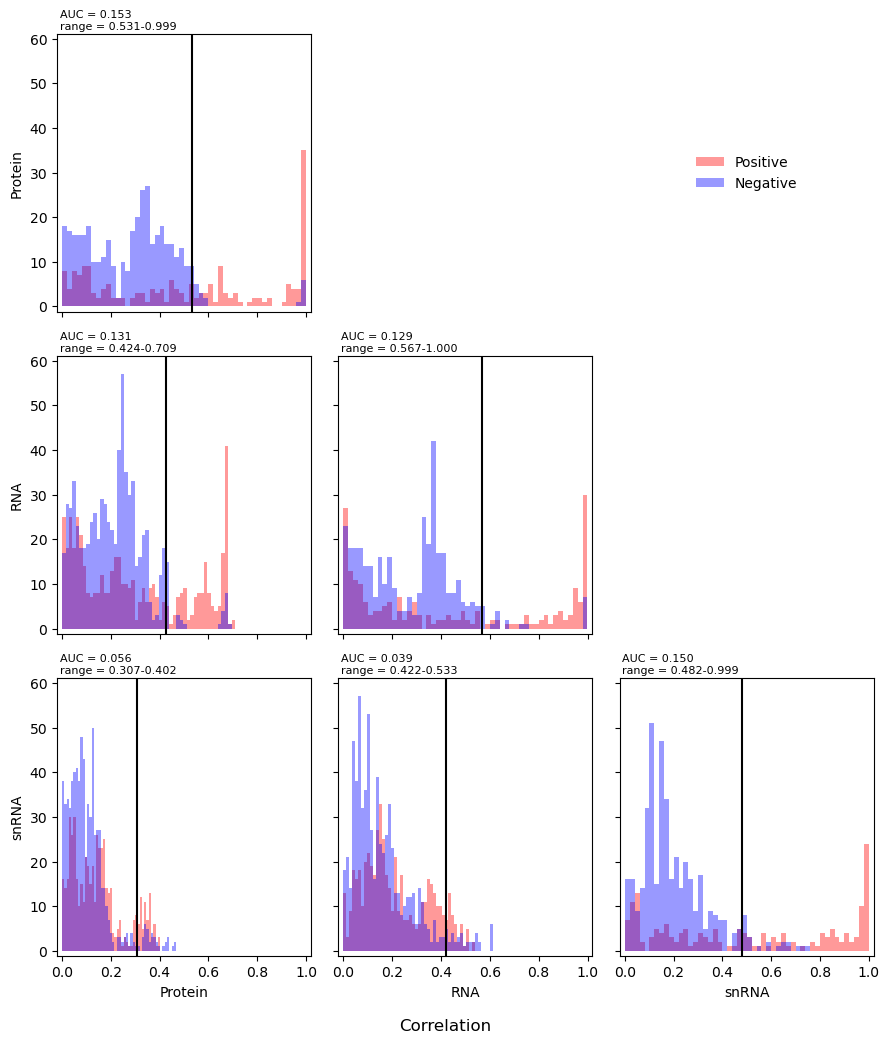

In [20]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [21]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
Protein       35      35   35      35        35      35
RNA           35      35   35      35        35      35
snRNA         35      35   35      35        35      35

As you can see, for this tutorial, since we chose low ranks at the beginning, no nodes were excluded due to node and edge filters.

## Create an SNS integration

2023-07-31 10:40:03,186 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-07-31 10:40:03,220 [INFO] Creating community network


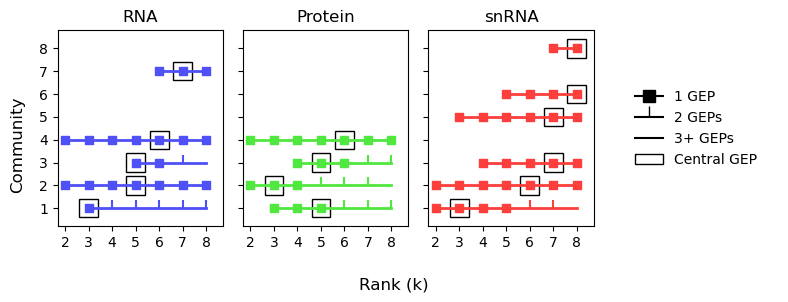

In [22]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors, figsize=[8, 3])

## Optional: prune communities with at least 2 datasets

2023-07-31 10:40:04,678 [INFO] Creating community network


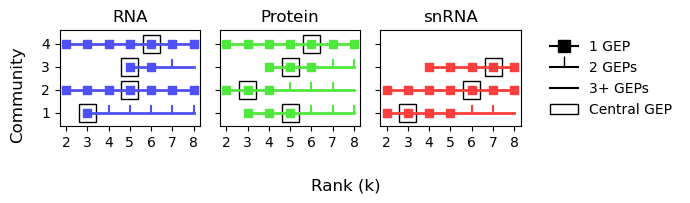

In [23]:
snsmap.prune_communities(min_datasets = 2)  # can also filter communities by number of nodes in total (min_nodes) and number of nodes per dataset (min_nodes_per_dataset)
fig = cn.plot_community_by_dataset_rank(snsmap, colors, figsize=[7, 2])

## Save SNS object and underlying data

In [24]:
snsmap.to_pkl("sns.pkl")

# to read it back, use this
snsmap = cn.SNS.from_pkl("sns.pkl")

# Plot an SNS Map

2023-07-31 14:31:05,504 [INFO] Computing community layout using spring method.


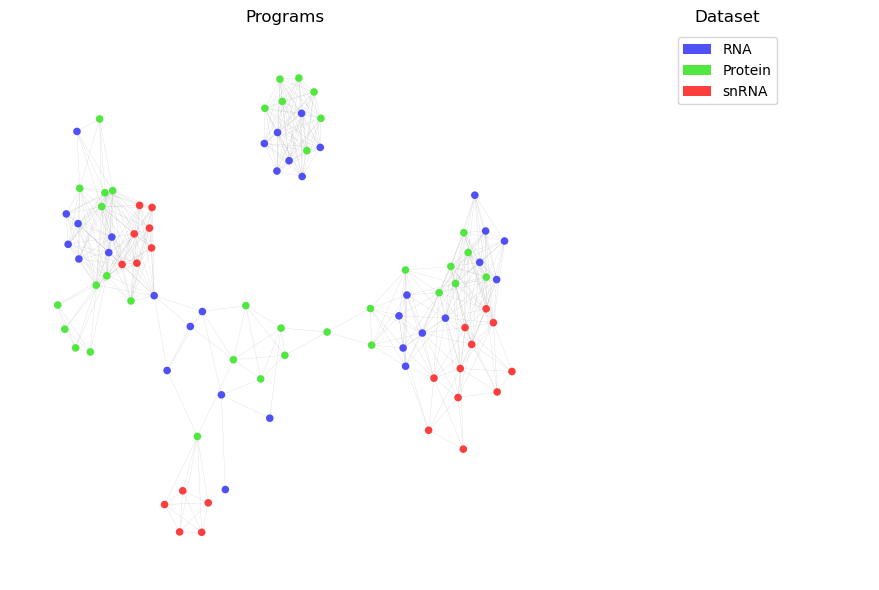

In [113]:
snsmap.compute_layout(algorithm="neato", community_layout_algorithm="spring")  # available algorithms: "community_weighted_spring", "spring", "neato"
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

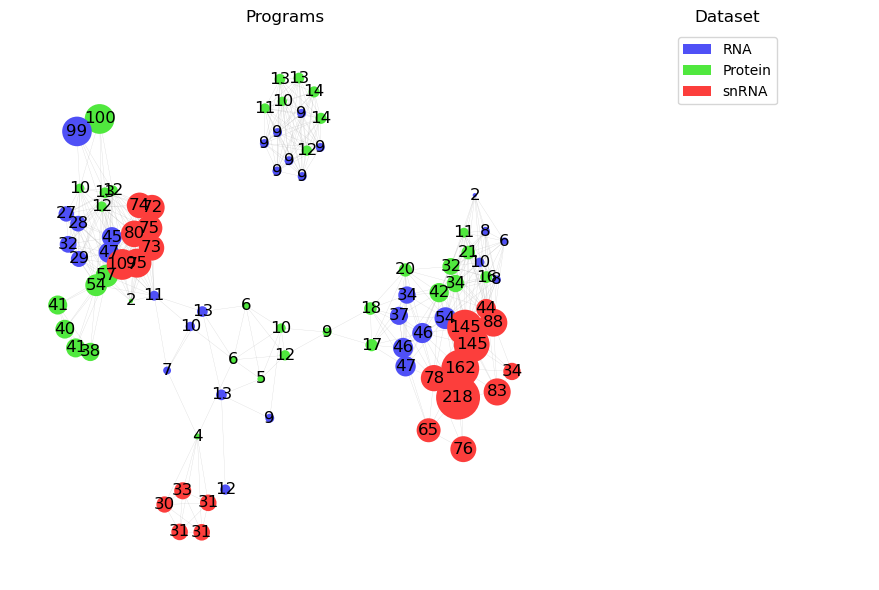

In [112]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

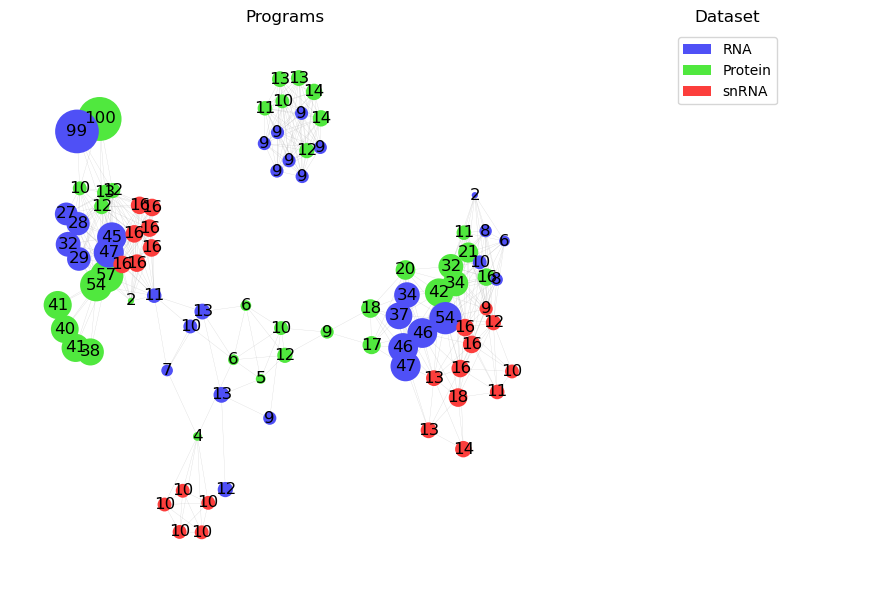

In [111]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)

Overrepresentation of sample categories for each program, based on the Protein dataset

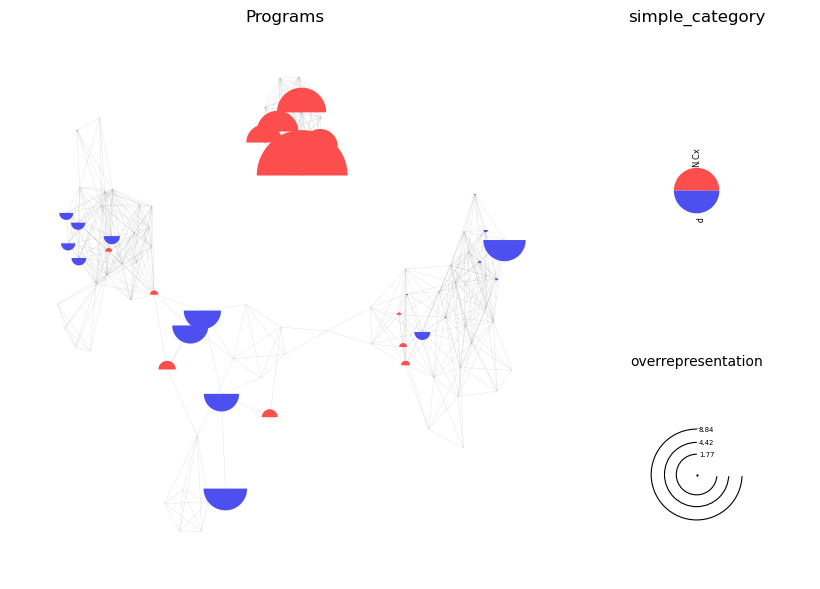

In [61]:
fig = cn.plots.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="RNA", layer="simple_category", pie_size=0.2)
fig.savefig("rna_tumor-normal_overrepresentation.pdf")

And again, using the CPTAC annotations

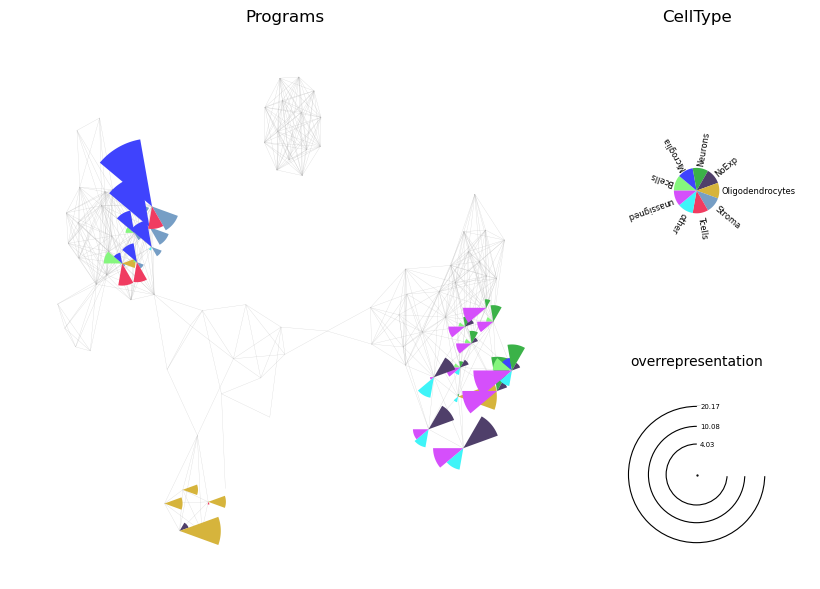

In [81]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="snRNA", layer="CellType")
fig.savefig("snRNA_celltype_overrepresentation.pdf")

You can also look at continuous metadata correlated with GEP usage, like estimated tumor purity (from bulk RNA and Protein datasets):

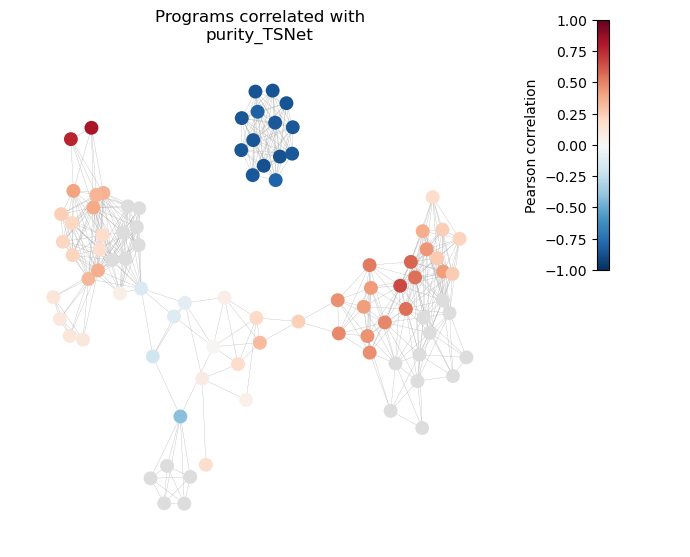

In [87]:
fig = cn.plot_metadata_correlation_gep_network(snsmap, colors, layer='purity_TSNet')

Note, that grey nodes have no "purity_TSNet" annotation track (these are the snRNA-Seq programs).

We can also look at correlation with percent mitochondrial reads in snRNA-Seq data:

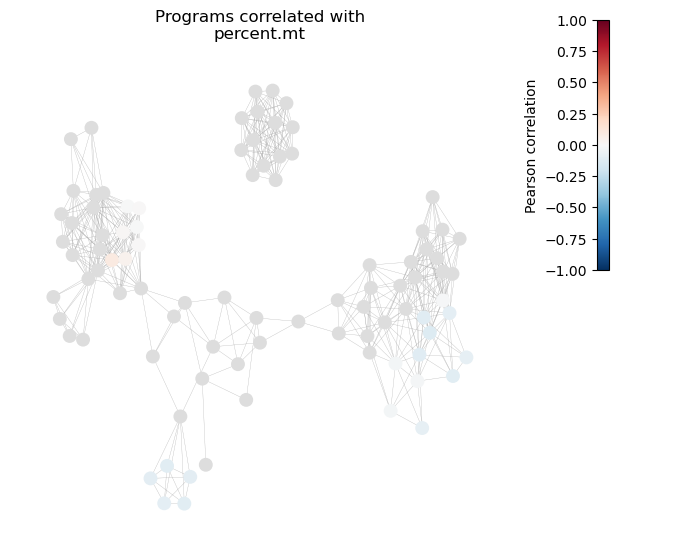

In [109]:
fig = cn.plot_metadata_correlation_gep_network(snsmap, colors, layer='percent.mt')

# Identifying GEP Communities

2023-07-31 14:30:55,669 [INFO] Choosing distinct community colors


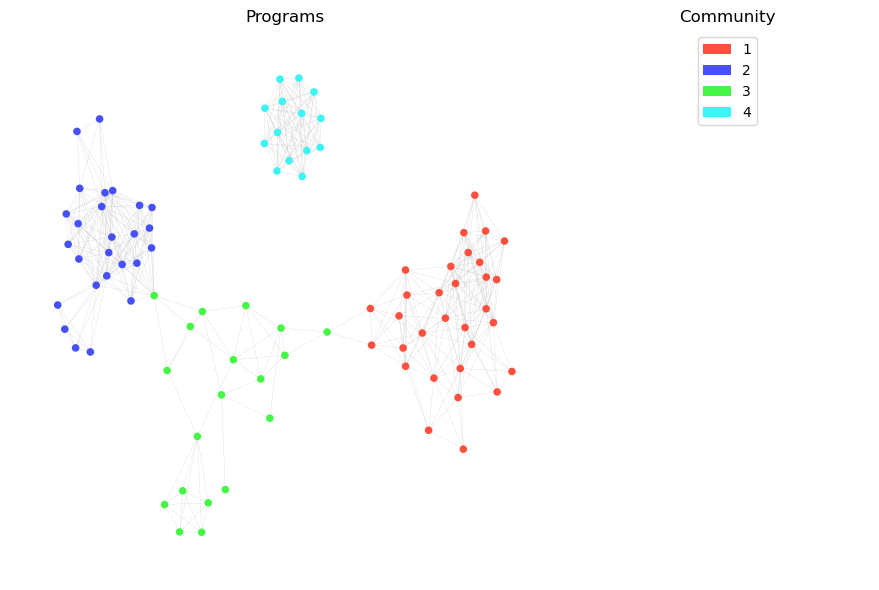

In [110]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

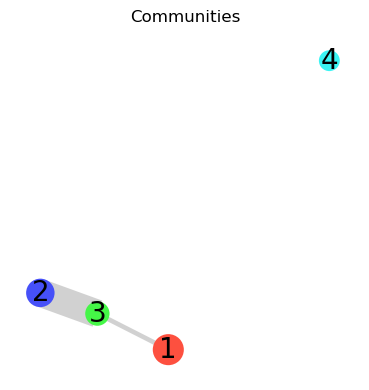

In [114]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot program usage heatmap summarized by Community

In [122]:
snsmap.integration.get_metadata_df()

patient_id simple_category detailed_category  \
RNA   C3L-00104                   C3L-00104               P                 P   
      C3L-00365                   C3L-00365               P                 P   
      C3L-00674                   C3L-00674               P                 P   
      C3L-00677                   C3L-00677               P                 P   
      C3L-01040                   C3L-01040               P                 P   
...                                     ...             ...               ...   
snRNA GTTACGAAGGTCGTCC-C3L-03968        NaN             NaN               NaN   
      TATTGGGAGTCTTGGT-C3L-03968        NaN             NaN               NaN   
      TCGGGTGGTAAGTCAA-C3L-03968        NaN             NaN               NaN   
      TGGTAGTGTACGTGTT-C3L-03968        NaN             NaN               NaN   
      TTTACCAGTAATGCTC-C3L-03968        NaN             NaN               NaN   

                                  purity_TSNet multiomic  \
RNA   C3L-00104                           0.73      nmf1   
      C3L-00365                           0.82      nmf3   
      C3L-00674                           0.50      nmf1   
      C3L-00677                           0.68      nmf1   
      C3L-01040                           0.54      nmf1   
...                                        ...       ...   
snRNA GTTACGAAGGTCGTCC-C3L-03968           NaN       NaN   
      TATTGGGAGTCTTGGT-C3L-03968           NaN       NaN   
      TCGGGTGGTAAGTCAA-C3L-03968           NaN       NaN   
      TGGTAGTGTACGTGTT-C3L-03968           NaN       NaN   
      TTTACCAGTAATGCTC-C3L-03968           NaN       NaN   

                                 r_wang_cancer_cell_2017 d_methyl  \
RNA   C3L-00104                                Proneural      dm2   
      C3L-00365                                Classical      dm4   
      C3L-00674                              Mesenchymal      dm5   
      C3L-00677                                Proneural      dm5   
      C3L-01040                                Classical      dm5   
...                                                  ...      ...   
snRNA GTTACGAAGGTCGTCC-C3L-03968                     NaN      NaN   
      TATTGGGAGTCTTGGT-C3L-03968                     NaN      NaN   
      TCGGGTGGTAAGTCAA-C3L-03968                     NaN      NaN   
      TGGTAGTGTACGTGTT-C3L-03968                     NaN      NaN   
      TTTACCAGTAATGCTC-C3L-03968                     NaN      NaN   

                                 d_methyl_mnp is_gcimp immune  ...  \
RNA   C3L-00104                   GBM, RTK II     TRUE    im2  ...   
      C3L-00365                   GBM, RTK II    FALSE    im2  ...   
      C3L-00674                      GBM, MES    FALSE    im1  ...   
      C3L-00677                      GBM, MES    FALSE    im4  ...   
      C3L-01040                      GBM, MES    FALSE    im4  ...   
...                                       ...      ...    ...  ...   
snRNA GTTACGAAGGTCGTCC-C3L-03968          NaN      NaN    NaN  ...   
      TATTGGGAGTCTTGGT-C3L-03968          NaN      NaN    NaN  ...   
      TCGGGTGGTAAGTCAA-C3L-03968          NaN      NaN    NaN  ...   
      TGGTAGTGTACGTGTT-C3L-03968          NaN      NaN    NaN  ...   
      TTTACCAGTAATGCTC-C3L-03968          NaN      NaN    NaN  ...   

                                 SCT_snn_res.0.2    CellType RNA_snn_res.0.5  \
RNA   C3L-00104                              NaN         NaN             NaN   
      C3L-00365                              NaN         NaN             NaN   
      C3L-00674                              NaN         NaN             NaN   
      C3L-00677                              NaN         NaN             NaN   
      C3L-01040                              NaN         NaN             NaN   
...                                          ...         ...             ...   
snRNA GTTACGAAGGTCGTCC-C3L-03968            11.0  unassigned            12.0   
      TATTGGGAGTCTTGGT-C3L-03

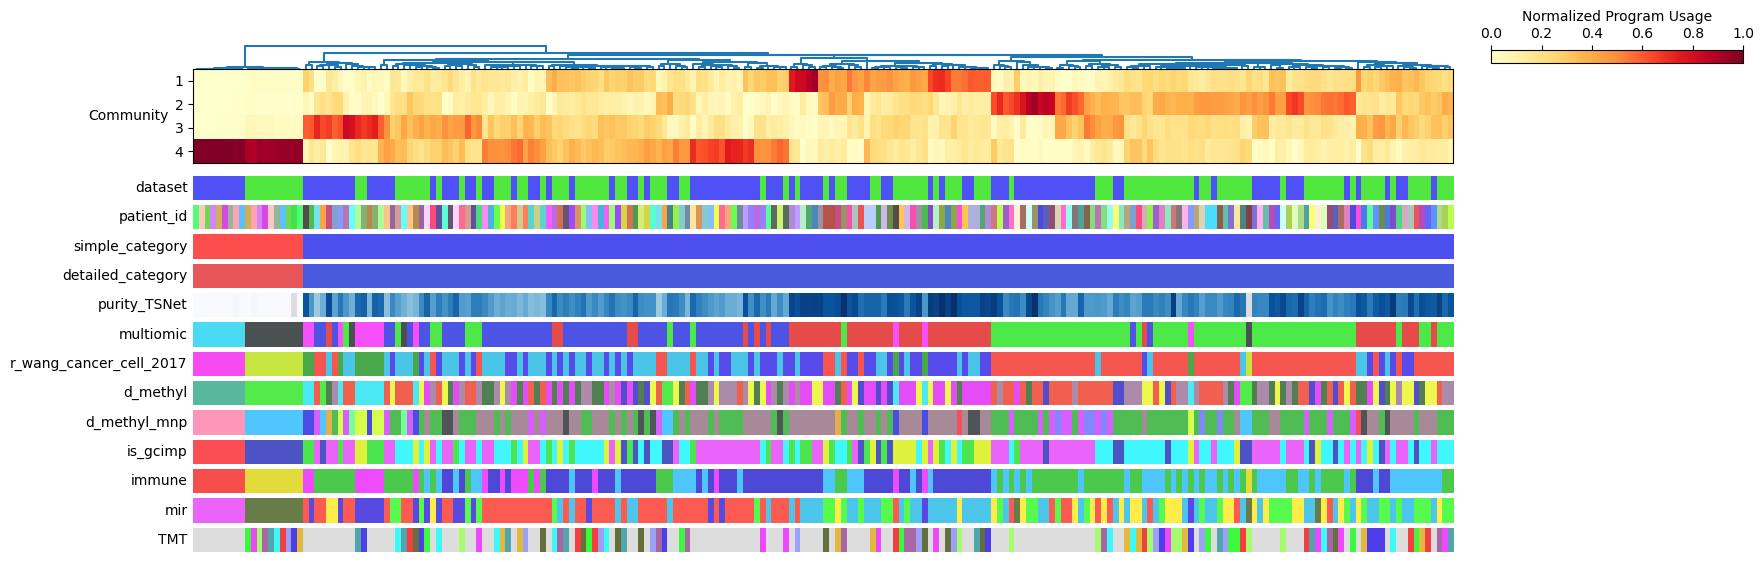

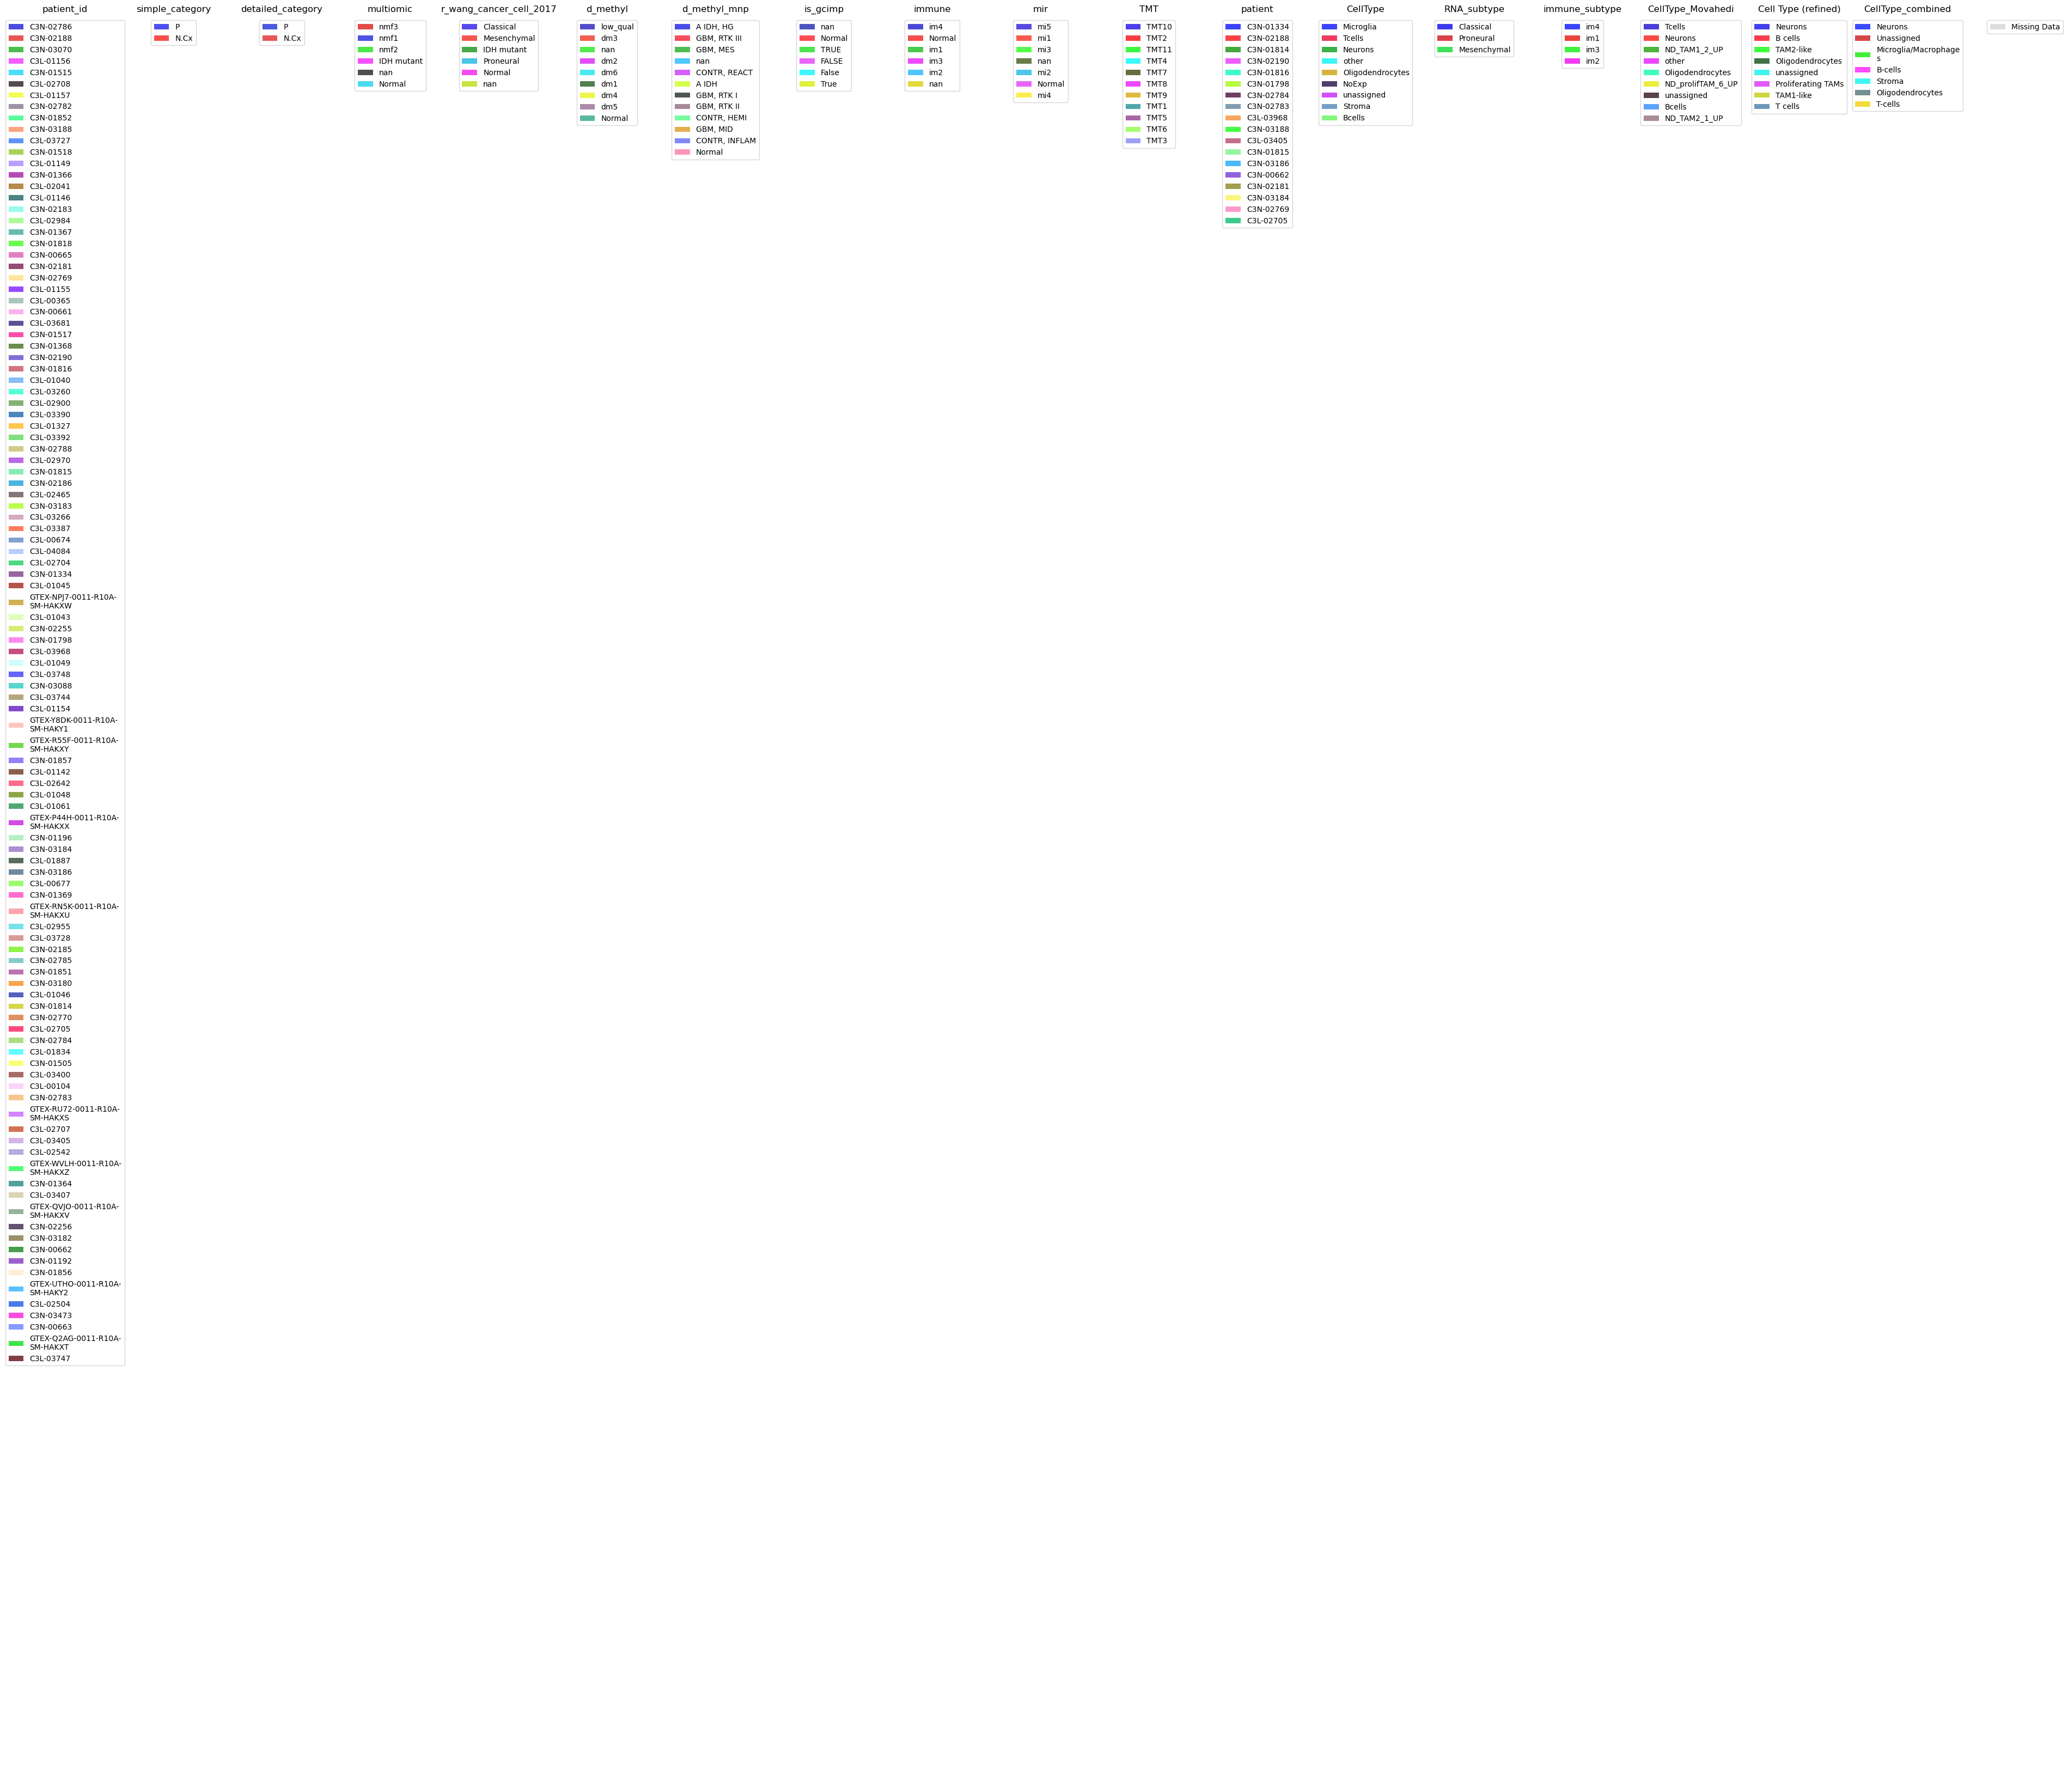

In [129]:
fig = cn.plot_community_usage_heatmap(snsmap, colors, subset_datasets=['RNA', 'Protein'], prepend_dataset_colors=True, show_sample_labels=False)
fig_legend = colors.plot_metadata_colors_legend()

## Correlate categorical variables with usage of individual programs, grouped by community

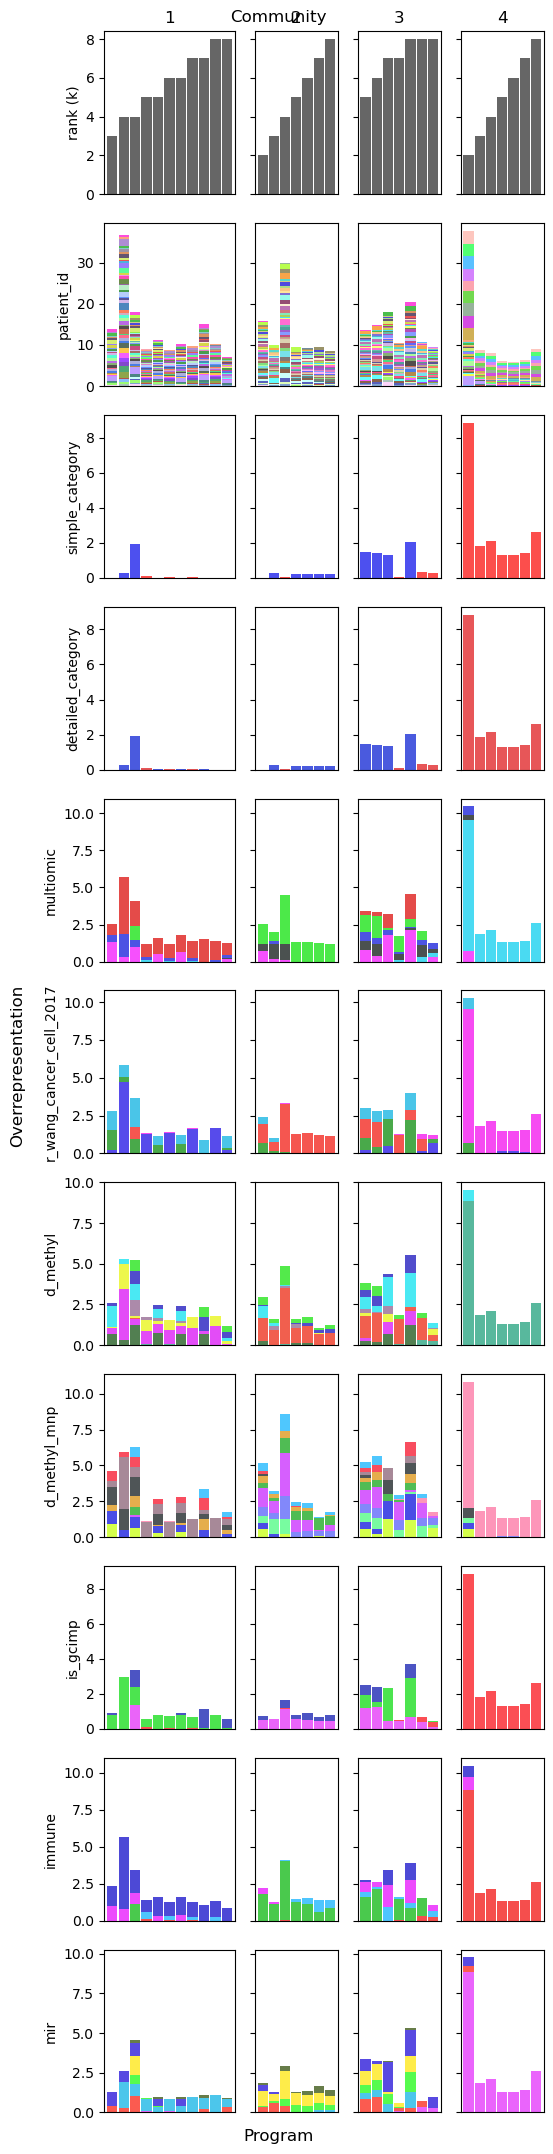

In [132]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="RNA")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlate programs in each community with continuous variables

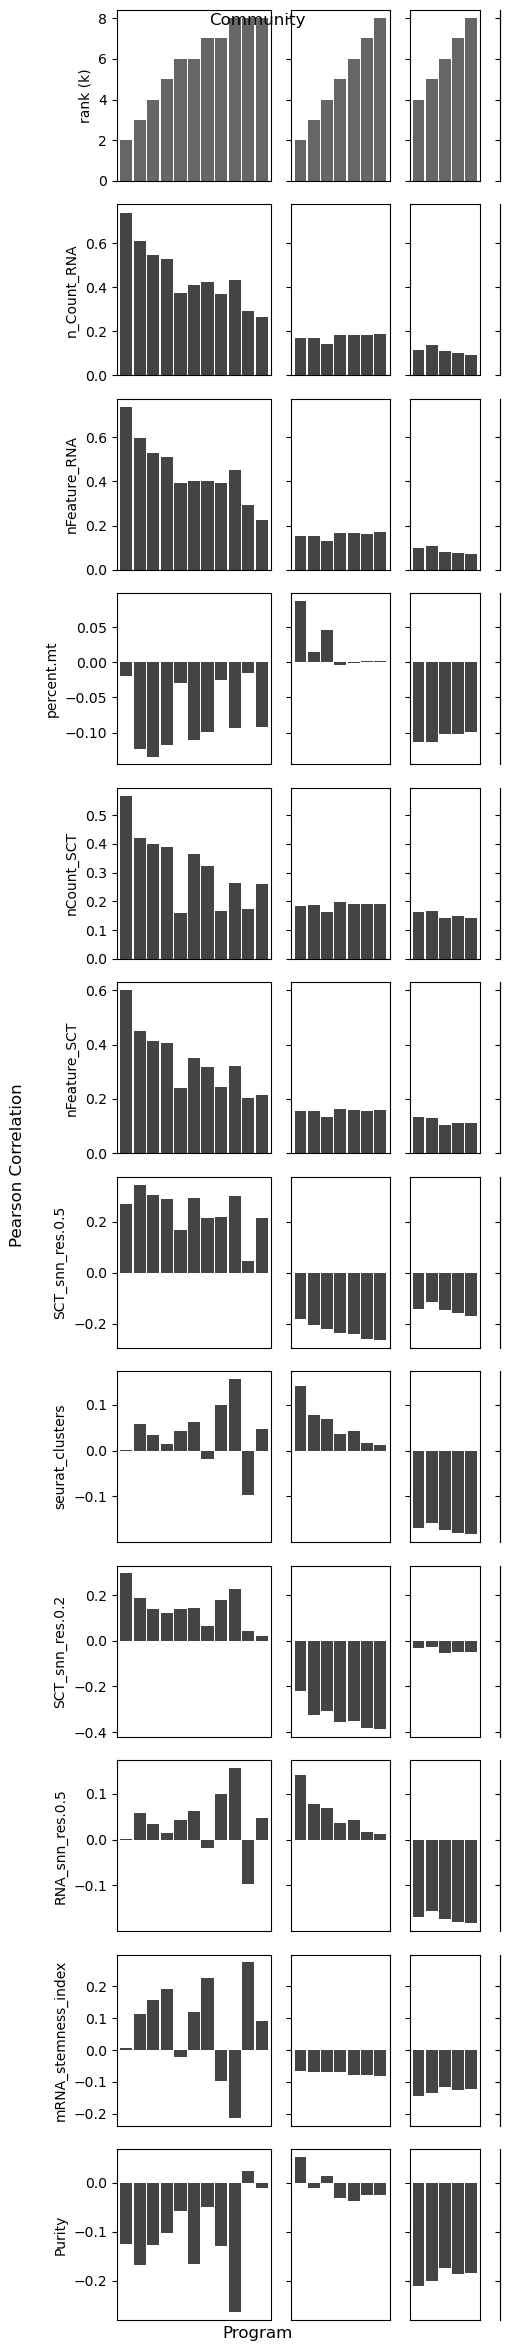

In [135]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="snRNA")

# Community-level summary of overrepresentation

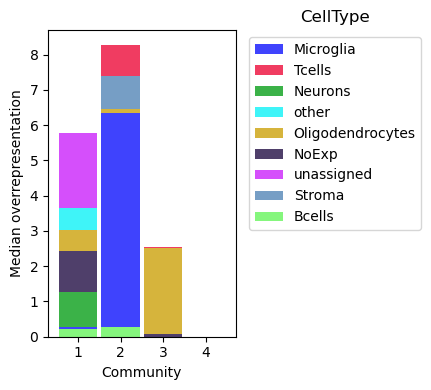

In [136]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="CellType", subset_datasets="snRNA")

Or, plot it on the network:

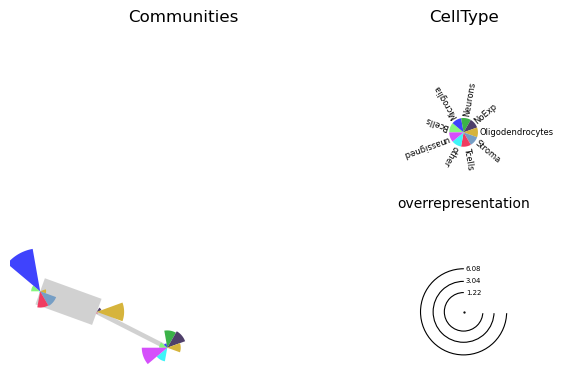

In [143]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer='CellType', subset_datasets="snRNA")

# Summarizing correlation with metadata

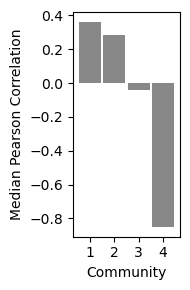

In [146]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer='purity_TSNet', subset_datasets="RNA", figsize=[2, 3])

Or, plot it on the network:

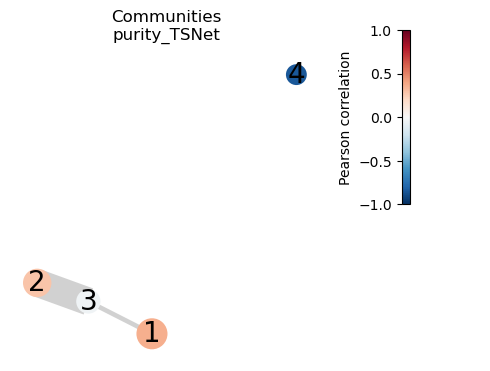

In [147]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer='purity_TSNet', subset_datasets="RNA")

# Shannon diversity of program usage by dataset

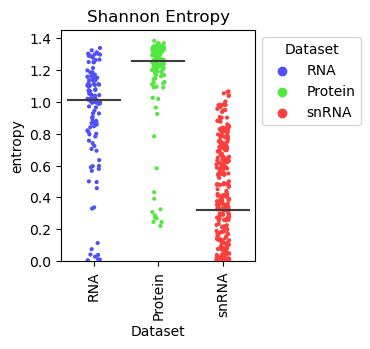

In [153]:
fig = cn.plot_sample_entropy(snsmap, colors)